# Variables de entorno

In [2]:
global scale, nconf, nchip, max_iter, n_pos, t_ext, tmax_chip, t_delta, tam
global chip_info
global input_filepath
global objective_function_HEAT

# Leer problema
Definir las funciones para leer la instancia del problema, y para escribir el fichero de input para el código C

In [3]:
# Lee los parámetros desde fichero
def read_params(filepath):
    global scale, nconf, nchip, max_iter, n_pos, t_ext, tmax_chip, t_delta, tam
    global chip_info
    
    initial_solution = []
    
    file = open(filepath,'r')
    params = file.readline().split()
    scale    = int(params[0])
    nchip    = int(params[1])
    max_iter = int(params[5])
    n_pos    = int(params[6])
    nconf    = 1
    t_ext     = float(params[2])
    tmax_chip = float(params[3])
    t_delta   = float(params[4])
    tam = (100*scale)//n_pos
    
    file.readline()
    for i in range(nchip):
        chip_info_line = file.readline().split()
        h = int(chip_info_line[0])
        w = int(chip_info_line[1])
        tchip = float(chip_info_line[2])
        chip_info.append((h,w,tchip))
        
    line = file.readline()
    
    if not line:
        print("Sin solución inicial")
    else:
        for _ in range(nconf):
            initial_solution.append(list())
            for __ in range(nchip):
                chip_position = file.readline().split()
                print(chip_position)
                x = int(chip_position[0])
                y = int(chip_position[1])
                initial_solution[len(initial_solution)-1].append((x,y))
            file.readline() 
     
    return initial_solution

# Lee los parámetros desde consola (TODO)   
def interactive_params():
    global scale, nconf, nchip, max_iter, n_pos, t_ext, tmax_chip, t_delta, tam
    global chip_info, chip_pos

    scale_tmp = input("scale: ")
    while not scale_tmp.isdigit() or int(scale_tmp)<1 or int(scale_tmp)>12:
        print("Not a integer between 1 and 12")
        scale_tmp = input("scale: ")
    scale = int(scale_tmp)
    
    nconf = 1
    
    # Por ahora un límite de 10 chips
    nchip_tmp = input("nchip: ")
    while not nchip_tmp.isdigit() or int(nchip_tmp)<1 or int(nchip_tmp)>10:
        print("Not a integer between 1 and 10")
        nchip_tmp = input("nchip: ")
    nchip = int(nchip_tmp)
    
    # Por ahora un límite de 1000 iteraciones para convergencia de fitness
    max_iter_tmp = input("max_iter: ")
    while not max_iter_tmp.isdigit() or int(max_iter_tmp)<1 or int(max_iter_tmp)>1000:
        print("Not a integer between 1 and 1000")
        max_iter_tmp = input("max_iter: ")
    max_iter = int(max_iter_tmp)
    
    n_pos_tmp = input("n_pos (divisor of {}): ".format(scale*100))
    while not n_pos_tmp.isdigit() or int(n_pos_tmp)<1 or ((scale*100)%int(n_pos_tmp) != 0):
        print("Must be positive integer divisor of {}".format(scale*100))
        n_pos_tmp = input("n_pos: ")
    n_pos = int(n_pos_tmp)
    
    tam = (scale*100)//n_pos
    
    # Por ahora un límite de 60 como temperatura inicial de la placa
    t_ext_tmp = input("t_ext: ")
    t_ext_tmp_check = t_ext_tmp.replace(".","")
    while not t_ext_tmp_check.isnumeric() or not ( 1 <= float(t_ext_tmp) <= 60.00):
        print("Not a float between 1 and 60")
        t_ext_tmp = input("t_ext: ")
        t_ext_tmp_check = t_ext_tmp.replace(".","")
    t_ext = float(t_ext_tmp)
    
    # Por ahora un límite de 200 como temperatura máxima de los chips
    tmax_chip_tmp = input("tmax_chip: ")
    tmax_chip_tmp_check = tmax_chip_tmp.replace(".","")
    while not tmax_chip_tmp_check.isnumeric() or not ( 1 <= float(tmax_chip_tmp) <= 200.00):
        print("Not a float between 1 and 200")
        tmax_chip_tmp = input("tmax_chip: ")
        tmax_chip_tmp_check = tmax_chip_tmp.replace(".","")
    tmax_chip = float(tmax_chip_tmp)
    
    # Por ahora un límite de 0.001 a 0.1 como t_delta
    t_delta_tmp = input("t_delta: ")
    t_delta_tmp_check = t_delta_tmp.replace(".","")
    while not t_delta_tmp_check.isnumeric() or not ( 0.001 <= float(t_delta_tmp) <= 0.1):
        print("Not a float between 0.001 and 0.1")
        t_delta_tmp = input("t_delta: ")
        t_delta_tmp_check = t_delta_tmp.replace(".","")
    t_delta = float(t_delta_tmp)
    
    for i in range(nchip):
        print("Enter info about chip {}".format(i))
        line = input("h w t_chip: ").split()
        h = line[0]
        w = line[1]
        t_chip = line[2]
    #     while not chip_correct(h,w,t_chip):
    #         print("Not correct values, h must be between 1 and {}; w must be bewteen 1 and {}, t_chip must be between 1 and {}".format(n_pos,2*n_pos,tmax_chip))
    #         line = input("h w t_chip: ").split()
    #         h = line[0]
    #         w = line[1]
    #         t_chip = line[2]
    #     chip_info.append((h,w,t_chip))
        
    # for i in range(nconf):
    #     print("Enter info about conf {}".format(i))
    #     line = input("x y: ").split()
    #     x = line[0]
    #     y = line[1]
    #     while not position_correct(x,y):
    #         print("Not correct values, x must be between 1 and {}; y must be bewteen 1 and {}".format(n_pos,2*n_pos,))
    #         line = input("x y: ").split()
    #         x = line[0]
    #         y = line[1]
    #     chip_pos.append((h,w,t_chip))
            
        # Meter info del chip en la lista
 
# Escribe el fichero de input para el código C
def write_card_file(filepath, solution : list):
    global scale, nconf, nchip, max_iter, n_pos, t_ext, tmax_chip, t_delta
    global chip_info
    
    file = open(filepath,'w')
    file.write("{} {} {} {} {} {} {}\n\n".format(scale,nconf,nchip,t_ext,tmax_chip,t_delta,max_iter))
    
    tam = (100*scale)//n_pos
    
    for (h,w,tchip) in chip_info:
        file.write("{} {} {}\n".format(h*tam,w*tam,tchip))
    
    file.write("\n")
    
    for configuration in solution:
        for (x,y) in configuration:
            file.write("{} {}\n".format(x*tam,y*tam))
        file.write("\n")
  

# Función objetivo
Preparar la librería para hacer la llamada a la función objetivo, ejecutar un ejemplo

In [4]:
import ctypes

def initialize_fitness():
    global objective_function_HEAT
    # Cargar la librería 
    objective_function_HEAT = ctypes.CDLL("lib/fitness.so")

    # Definir el tipo de los argumentos que se le pasan (relevante) y el del resultado (irrelevante)
    objective_function_HEAT.fitness.argtypes = [ctypes.c_int, ctypes.c_char_p, ctypes.POINTER(ctypes.c_double), ctypes.POINTER(ctypes.c_double)]
    objective_function_HEAT.fitness.restype = ctypes.c_int

def fitness_heat(filepath,salida = False):
    global objective_function_HEAT
    # Preparar las variables de argumento
    input_string = filepath.encode('utf-8')  # Necesario convertirlo a char* para C
    if not salida:
        input_int = 0
    else:
        input_int = 1
    Tmean = ctypes.c_double()
    Tej = ctypes.c_double()

    # Ejecución
    objective_function_HEAT.fitness(input_int, input_string, ctypes.byref(Tmean), ctypes.byref(Tej))
    
    return Tmean.value,Tej.value

def valid_solution(solution : list, chip_info : list, n_pos : int, scale : int, tam : int):
    n_filas = n_pos*2
    n_columnas = n_pos
    n_chips = len(solution)

    # Verificar que ningún chip se salga de la placa
    for i in range(n_chips):
        x, y = solution[i]
        ancho, alto, _ = chip_info[i]

        if x < 0 or x + ancho > n_filas or y < 0 or y + alto > n_columnas:
            return False  # El chip se sale de la placa

    # Verificar que ningún chip solape con otro chip
    for i in range(n_chips - 1):
        x1, y1 = solution[i]
        ancho1, alto1, _= chip_info[i]

        for j in range(i + 1, n_chips):
            x2, y2 = solution[j]
            ancho2, alto2, _ = chip_info[j]

            if (x1 < x2 + ancho2 and x1 + ancho1 > x2 and
                y1 < y2 + alto2 and y1 + alto1 > y2):
                return False  # Los chips se solapan

    return True  # Todas las condiciones son válidas

initialize_fitness()
fitness_value, fitness_time = fitness_heat(filepath='data/card',salida=False)
print("Valor fitness: ",fitness_value)
print("Ha tardado {} segundos".format(fitness_time))


Valor fitness:  72.95249938964844
Ha tardado 1.178393303 segundos


# Funciones para calidad de vida

In [5]:
import matplotlib.pyplot as plt

def visualizar_solucion(solution : list):
    global scale, nconf, nchip, max_iter, n_pos, t_ext, tmax_chip, t_delta, tam
    global chip_info
    global input_filepath
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(20, 10))  

    # Dibujar la placa
    for i in range(n_pos*2 + 1):
        y = i * tam
        ax.plot([0, scale * 100], [y, y], color='gray', linestyle='--', linewidth=0.5)

    for i in range(n_pos + 1):
        x = i * tam
        ax.plot([x, x], [0, scale * 200], color='gray', linestyle='--', linewidth=0.5)

    # Dibujar los chips en la placa
    for i, (chip, posicion) in enumerate(zip(chip_info, solution)):
        y, x = posicion  # Invertir las coordenadas
        x_real = x * tam  # Usar alto_pos para el eje horizontal
        y_real = y * tam  # Usar ancho_pos para el eje vertical
        alto, ancho, temperatura = chip  # Invertir las dimensiones
        alto_real = alto * tam
        ancho_real = ancho * tam

        # Asignar un color diferente a cada chip
        color = plt.colormaps.get_cmap('tab10')(i)
        

        # Dibujar el rectángulo con el color y la etiqueta
        rect = plt.Rectangle((x_real, y_real), ancho_real, alto_real, linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

        # Mostrar el nombre del chip y su temperatura dentro del rectángulo
        texto = f'C{i+1} - {temperatura}°C'
        ax.text(x_real + ancho_real / 2, y_real + alto_real / 2, texto, color='black',
                ha='center', va='center', fontsize=8, fontweight='bold')

    # Configurar etiquetas y título
    ax.set_xlabel('Alto de la placa - x')  # Cambiar las etiquetas
    ax.set_ylabel('Ancho de la placa - y')
    ax.set_title("Placa del fichero {}".format(input_filepath))

    # Mostrar la placa
    plt.show()

def print_general_params():
    global scale, nconf, nchip, max_iter, n_pos, t_ext, tmax_chip, t_delta, tam
    global chip_info
    global input_filepath
    
    print("scale is: {}".format(scale))
    print("nconf is: {}".format(nconf))
    print("nchip is: {}".format(nchip))
    print("t_ext is: {}".format(t_ext))
    print("tmax_chip is: {}".format(tmax_chip))
    print("t_delta is: {}".format(t_delta))
    print("max_iter is: {}".format(max_iter))
    print("n_pos is: {}".format(n_pos))
    print("tam is: {}".format(tam))
    print("chip_info is: ",chip_info)
    print("Input file is: ", input_filepath)

def clear_all():
    global chip_info
    chip_info = []

# Ejecución con solución inicial

['10', '10']
['24', '6']
['6', '1']
['1', '1']
['10', '10']
['24', '6']
['6', '1']
['1', '1']
['10', '10']
['24', '6']
['6', '1']
['1', '1']
['10', '10']
['24', '6']
['6', '1']
['1', '1']


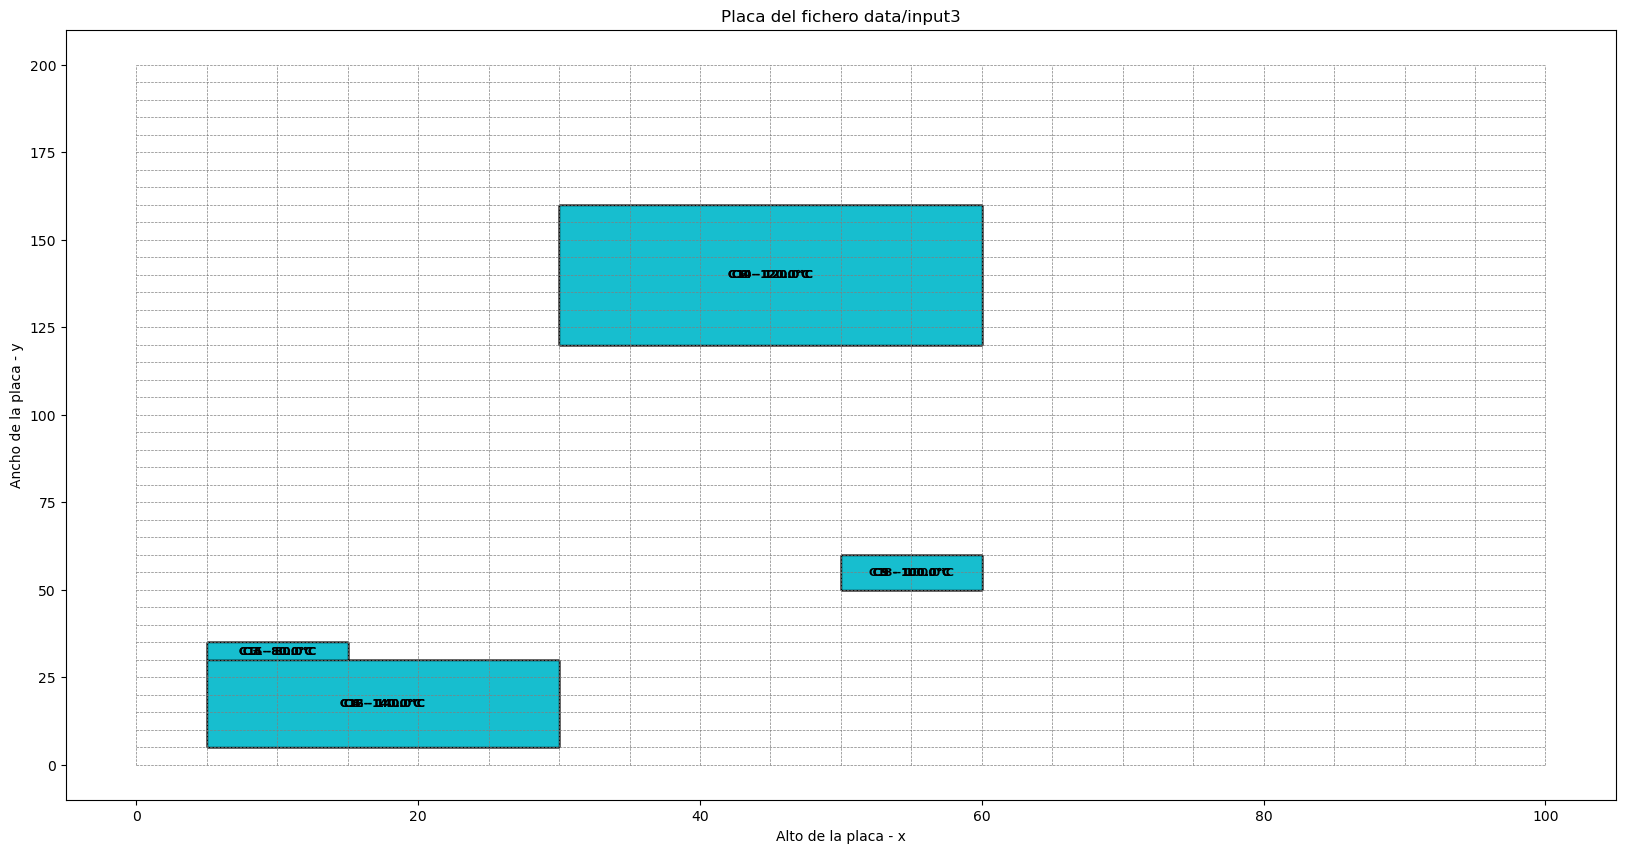

fitness: 16.0
Time: 0.006620288 segundos


In [61]:
input_filepath = 'data/input3'
output_filepath = 'data/card3'

clear_all()
initialize_fitness()

initial_sol = read_params(filepath = input_filepath)
write_card_file(filepath= output_filepath, solution= initial_sol)
visualizar_solucion(initial_sol[0])

fitness, time = fitness_heat(filepath=output_filepath,salida=False)
print("fitness:",fitness)
print("Time:",time, "segundos")

# Solución inicial estocástica y vecindades

[(3, 10), (17, 0), (31, 6), (28, 14), (36, 14), (8, 8), (39, 4), (23, 6)]


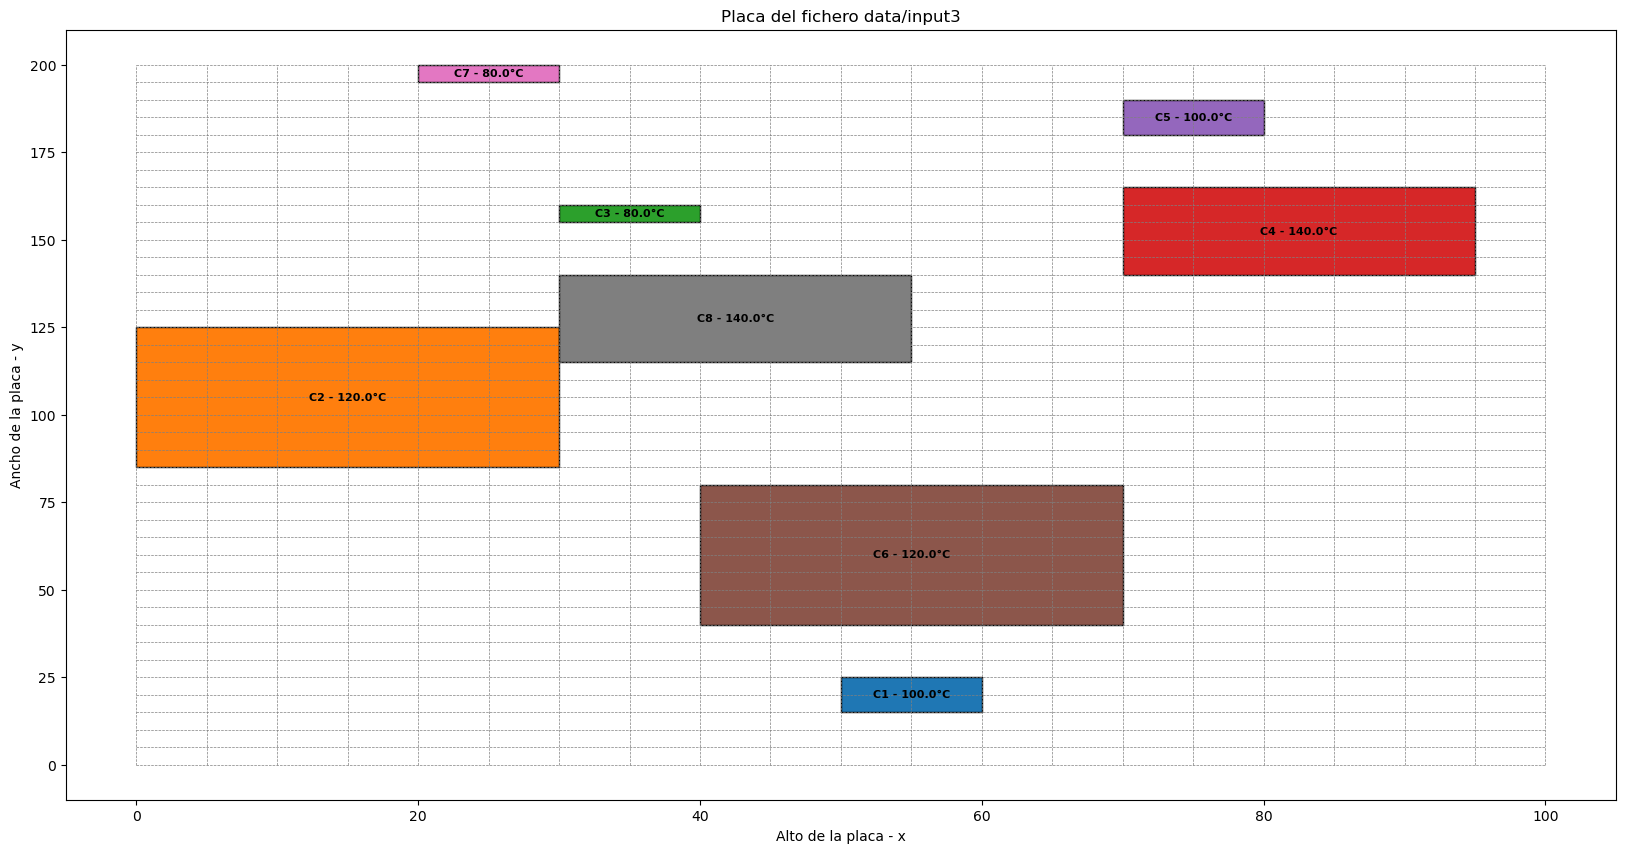

In [30]:
import random as rm

def random_solution(nchip, n_pos):
    global scale,tam
    global chip_info
    sol = [[]]
    for i in range(nchip):
        ancho,alto,_ = chip_info[i]
        x = rm.randint(0,n_pos*2)
        y = rm.randint(0,n_pos)
        sol[0].append((x,y))
        valid = valid_solution(sol[0],chip_info,n_pos,scale,tam)
        while not valid:
            x = rm.randint(0,n_pos*2)
            y = rm.randint(0,n_pos)
            sol[0][len(sol[0])-1] = (x,y)
            valid = valid_solution(sol[0],chip_info,n_pos,scale,tam)
            
    return sol

rand_sol = random_solution(nchip,n_pos)
print(rand_sol[0])
visualizar_solucion(rand_sol[0])    
        

# Función de vecindad
Dos funciones de vecindad
1. Mueve un chip una posición en cualquiera de los 8 sentidos
2. Swap entre dos chips

In [38]:
def move_1 (solucion : list):
    global chip_info,n_pos,scale,tam
    result = [[]]
    for i in range(nchip):
        x,y = solucion[0][i]
        vecino_0 = solucion.copy()
        vecino_1 = solucion.copy()
        vecino_2 = solucion.copy()
        vecino_3 = solucion.copy()
        vecino_4 = solucion.copy()
        vecino_5 = solucion.copy()
        vecino_6 = solucion.copy()
        vecino_7 = solucion.copy()
        
        vecino_0[0] = vecino_0[0][:i] + [((x-1)%(n_pos*2), (y-1)%n_pos)] + vecino_0[0][i+1:]
        vecino_1[0] = vecino_1[0][:i] + [((x)  %(n_pos*2), (y-1)%n_pos)] + vecino_1[0][i+1:]
        vecino_2[0] = vecino_2[0][:i] + [((x+1)%(n_pos*2), (y-1)%n_pos)] + vecino_2[0][i+1:]
        vecino_3[0] = vecino_3[0][:i] + [((x-1)%(n_pos*2), (y)  %n_pos)] + vecino_3[0][i+1:]
        vecino_4[0] = vecino_4[0][:i] + [((x+1)%(n_pos*2), (y)  %n_pos)] + vecino_4[0][i+1:]
        vecino_5[0] = vecino_5[0][:i] + [((x-1)%(n_pos*2), (y+1)%n_pos)] + vecino_5[0][i+1:]
        vecino_6[0] = vecino_6[0][:i] + [((x)  %(n_pos*2), (y+1)%n_pos)] + vecino_6[0][i+1:]
        vecino_7[0] = vecino_7[0][:i] + [((x+1)%(n_pos*2), (y+1)%n_pos)] + vecino_7[0][i+1:]
        
        if valid_solution(vecino_0[0],chip_info,n_pos,scale,tam):
            result[0].append(vecino_0[0].copy())
        if valid_solution(vecino_1[0],chip_info,n_pos,scale,tam):
            result[0].append(vecino_1[0].copy())
        if valid_solution(vecino_2[0],chip_info,n_pos,scale,tam):
            result[0].append(vecino_2[0].copy())
        if valid_solution(vecino_3[0],chip_info,n_pos,scale,tam):
            result[0].append(vecino_3[0].copy())
        if valid_solution(vecino_4[0],chip_info,n_pos,scale,tam):
            result[0].append(vecino_4[0].copy())
        if valid_solution(vecino_5[0],chip_info,n_pos,scale,tam):
            result[0].append(vecino_5[0].copy())
        if valid_solution(vecino_6[0],chip_info,n_pos,scale,tam):
            result[0].append(vecino_6[0].copy())
        if valid_solution(vecino_7[0],chip_info,n_pos,scale,tam):
            result[0].append(vecino_7[0].copy())
    return result

def swap_2(solucion):
    global chip_info, n_pos, scale, tam
    result = [[]]

    for i in range(nchip):
        for j in range(i + 1, nchip):
            vecino_swap = solucion[0].copy()

            # Intercambiar las posiciones de los chips i y j
            vecino_swap[i], vecino_swap[j] = vecino_swap[j], vecino_swap[i]

            # Verificar si la solución resultante es válida
            if valid_solution(vecino_swap, chip_info, n_pos, scale, tam):
                result[0].append(vecino_swap.copy())

    return result

rand_sol = random_solution(nchip,n_pos)
print("Solución inicial aleatoria:",rand_sol)
# visualizar_solucion(rand_sol[0]) 
   
vecindad_1 = move_1(rand_sol)
print("Vecindad move_1:",vecindad_1[0])
print("Tam vecindad move_1:",len(vecindad_1[0]))
# for elem in vecindad_1[0]:
#     visualizar_solucion(elem)  

vecindad_2 = swap_2(rand_sol)
print("Vecindad swap_2:",vecindad_2[0])
print("Tam vecindad swap_2:",len(vecindad_2[0]))  
# for elem in vecindad_2[0]:
#     visualizar_solucion(elem)  

Solución inicial aleatoria: [[(8, 15), (11, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)]]
Vecindad move_1: [[(7, 14), (11, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(8, 14), (11, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(9, 14), (11, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(7, 15), (11, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(9, 15), (11, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(7, 16), (11, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(8, 16), (11, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(9, 16), (11, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(8, 15), (10, 6), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(8, 15), (11, 6), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(8, 15), (12, 6), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), (0, 1)], [(8, 15), (10, 7), (6, 5), (29, 4), (19, 1), (31, 14), (25, 10), 

# Búsquedas baseline 
Random Search
Brute force (?)

Best fitness: 8.0
Best fitness codif: [[(32, 15), (30, 5), (38, 6), (9, 7), (0, 2), (6, 12), (22, 6), (27, 15)]]
Total time: 7.110281090999993


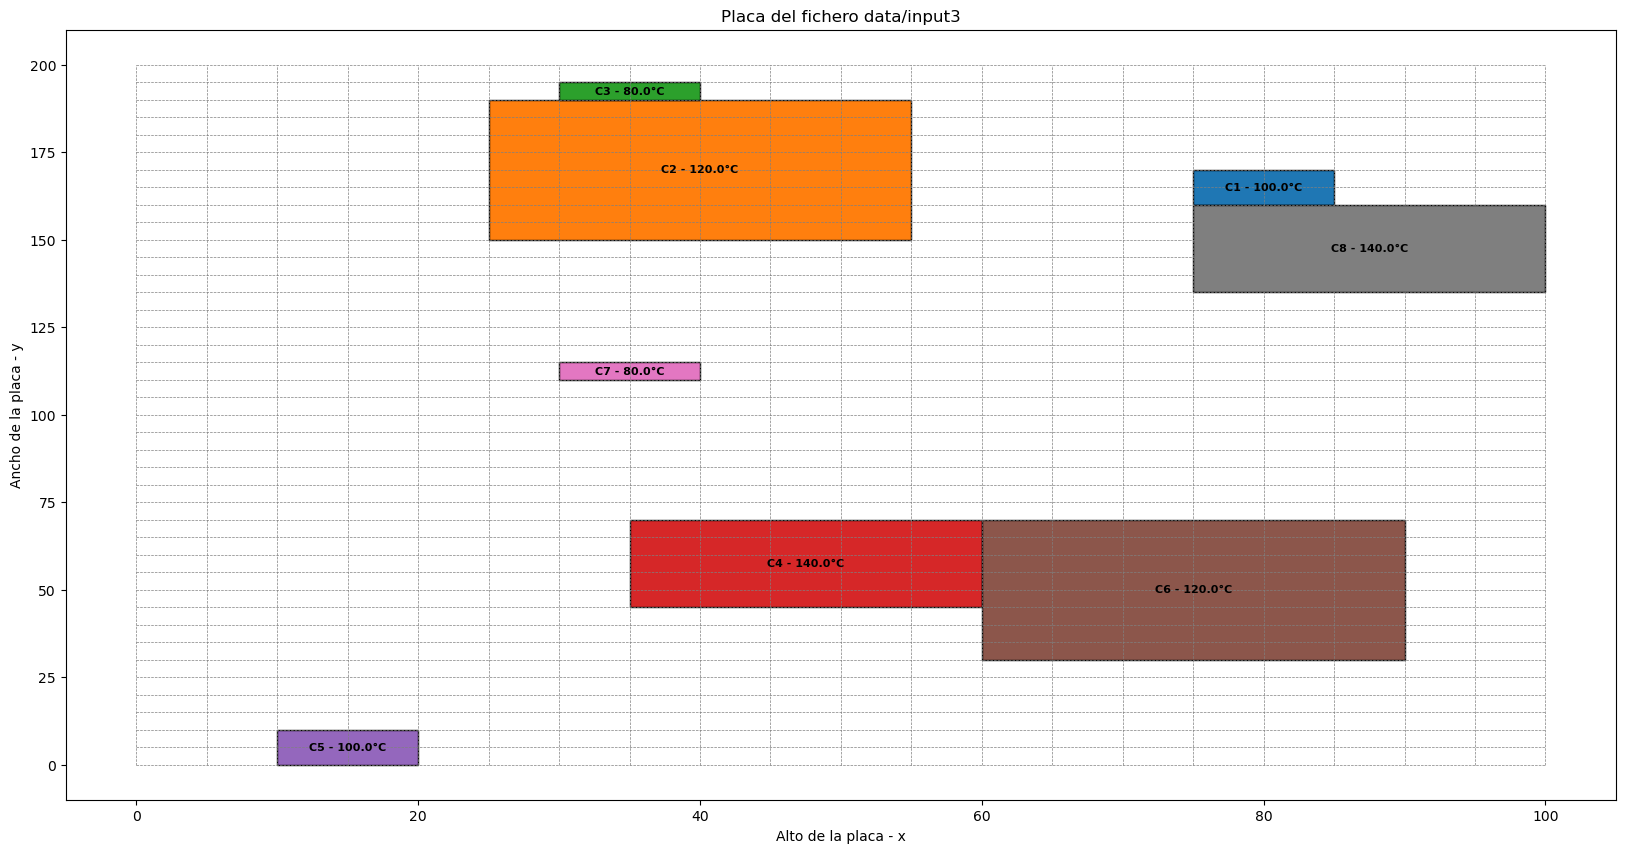

In [32]:
import sys

def random_search(instance : list , num_solutions : int) -> list:
    nchip,n_pos = instance
    best_sol_codif = random_solution(nchip,n_pos)
    best_sol_value = sys.float_info.max
    total_time = 0

    sol_actual_codif = best_sol_codif.copy()
    sol_actual_value = 0

    for _ in range(num_solutions):
        sol_actual_codif = random_solution(nchip,n_pos)
        write_card_file(filepath="card_tmp",solution=sol_actual_codif)
        sol_actual_value, sol_actual_time = fitness_heat(filepath="card_tmp",salida=False)
        total_time += sol_actual_time
        if sol_actual_value < best_sol_value:
            best_sol_value = sol_actual_value
            best_sol_codif = sol_actual_codif

    return best_sol_value,best_sol_codif, total_time

instance = nchip,n_pos
best_sol_value, best_sol_codif, total_time = random_search(instance,1000)
print("Best fitness:",best_sol_value)
print("Best fitness codif:",best_sol_codif)
print("Total time:",total_time)
visualizar_solucion(best_sol_codif[0])

# Basic Hill Climbing - Búsqueda Local

New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitness: 16.0
New fitnes

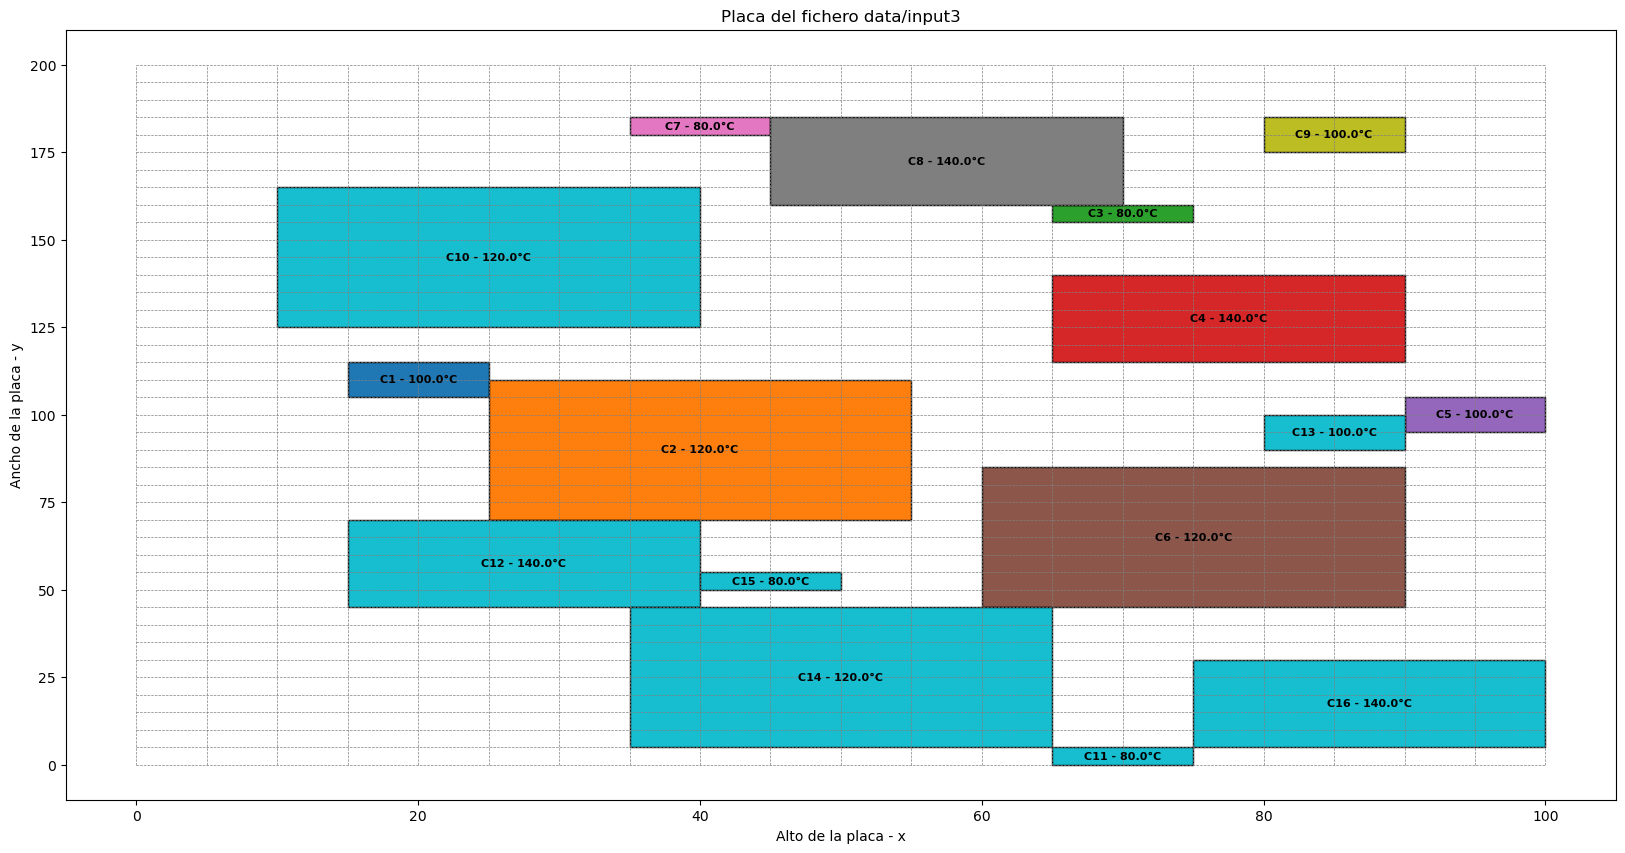

In [62]:
def best_first_move(instance: list, candidato: list, fitness_candidato : float, max_eval : int, n_eval : int):
    current_sol = candidato.copy()
    current_fitness = fitness_candidato

    iter_count = n_eval
    mejora = True
    total_time = 0

    # Mientras no sobrepasen las iteraciones o no se encuentre mejora
    while (iter_count < max_eval and mejora):
      # Se obtiene la vecindad
      vecindad = move_1(current_sol)

      # Se recorren los vecinos hasta encontrar uno con mejor solucion
      sol_ind = 0
      encontrado = False

      # Se recorren los vecinos hasta encontrar el primero que mejore la función fitness
      while (sol_ind < len(vecindad[0]) and not encontrado):
        if (iter_count > max_eval):
          break
        # Se calcula el fitness de uno de los vecinos
        write_card_file(filepath="card_tmp",solution=[vecindad[0][sol_ind]])
        new_fitness, new_time = fitness_heat(filepath="card_tmp",salida=False)
        total_time += new_time
        iter_count = iter_count + 1
        # Si mejora el fitness se sigue ese camino
        if (new_fitness < current_fitness):
          print("Fitness mejorado de {} a {}".format(current_fitness,new_fitness))
          current_fitness = new_fitness
          current_sol = vecindad[sol_ind]
          encontrado = True
        sol_ind = sol_ind + 1

      # Si no se ha encontrado un vecino que mejore, no merece seguir buscando
      if not encontrado:
        mejora = False

    best_fitness = current_fitness
    best_solution = current_sol
    return best_fitness,best_solution,iter_count, total_time
  
# Preparar los datos
instance = nchip, n_pos
candidato = random_solution(nchip,n_pos)
write_card_file(filepath="card_tmp",solution=candidato)
fitness_candidato, _ = fitness_heat(filepath="card_tmp",salida=False)
max_eval = 1000
n_eval = 1

# Hacer la búsqueda local
best_sol_value, best_sol_codif, iter_count, total_time = best_first_move(instance,candidato,fitness_candidato,max_eval,n_eval)

# Comprobar los resultados
print("Best fitness:",best_sol_value)
print("Best fitness codif:",best_sol_codif)
print("Iterations used:",iter_count)
print("Total time:",total_time)
visualizar_solucion(best_sol_codif[0])
